In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nuance.utils import periodic_transit
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


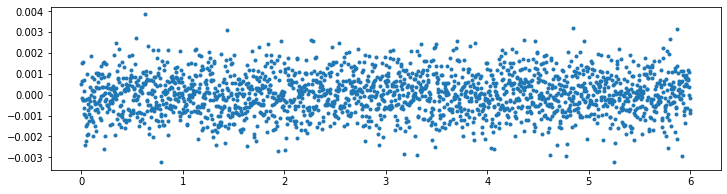

In [2]:
np.random.seed(42)
time = np.linspace(0, 6, 2000)
diff_error = 0.001
X = np.vander(time, N=4, increasing=True)
w = [1., 0.05, -0.2, -0.5]
true_transit = periodic_transit(time, 0.2/4, 0.05, 0.0005, P=1.3)
diff_flux = true_transit + np.random.normal(0., diff_error, size=len(time)) #+ X@w

plt.figure(None, (12, 3))
plt.plot(time, diff_flux, ".")

## Single transit (linear) search

In [3]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

gp = GaussianProcess(kernels.quasisep.Exp(1e15), time, diag=diff_error**2, mean=1.)
nu = Nuance(time, diff_flux, gp, X.T)

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
ll, z, vz = nu.linear_search(t0s, Ds)

  0%|          | 0/2000 [00:00<?, ?it/s]

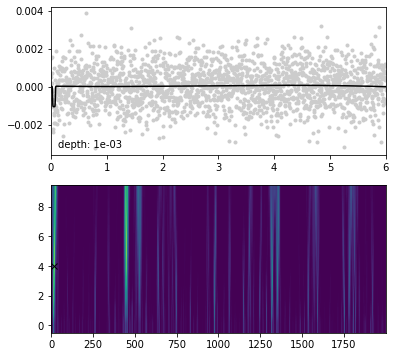

In [4]:
i, j = np.unravel_index(np.argmax(ll), ll.shape)
t0, D = t0s[i], Ds[j]
mean, astro, noise = nu.models(t0, D)

plt.figure(None, (6, 6))
plt.subplot(211)
plt.plot(time, diff_flux, ".", c="0.8")
plt.plot(time, mean + astro + noise, c="k")
plt.xlim(time.min(), time.max())
plt.text(0.02, 0.05, f"depth: {nu.depth(t0, D)[0]:2.0e}", transform=plt.gca().transAxes)
plt.subplot(212)
plt.plot(i, j, "x", c="k")
plt.imshow(ll.T, aspect='auto', origin="lower")

## Periodic search

In [5]:
periods = np.linspace(1, 5, 5000)

llc, llv = nu.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

period: 1.300


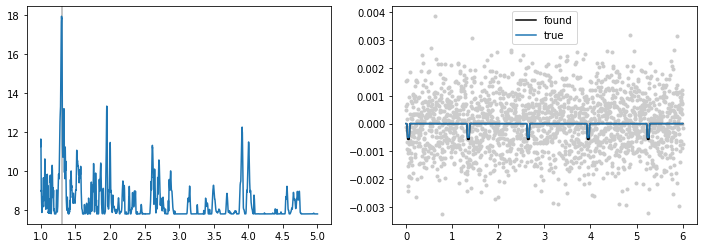

In [6]:
# periodogram
i, j = np.unravel_index(np.argmax(llv), llv.shape)
p0 = periods[i]
print(f"period: {p0:.3f}")

# best model
t0, D = nu.best_periodic_transit(p0)
m = periodic_transit(time, t0,  D, 1, P=p0)
mean, astro, noise = nu.models_m(m)

plt.figure(None, (12, 4))
plt.subplot(121)
plt.axvline(p0, c="k", alpha=0.3)
plt.plot(periods, llv.T[j])
plt.subplot(122)
plt.plot(time, diff_flux, ".", c="0.8")
plt.plot(time, astro+noise, c="k", label="found")
plt.plot(time, true_transit, c="C0", label="true")
_ = plt.legend()